Contains additional data related to the store, department, and regional activity for the given dates.

Store - the store number
Date - the week
Temperature - average temperature in the region
Fuel_Price - cost of fuel in the region
MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
CPI - the consumer price index
Unemployment - the unemployment rate
IsHoliday - whether the week is a special holiday week
Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week

In [1]:
# Librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from kmodes.kmodes import KModes
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import roc_curve, roc_auc_score, auc
import random
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Get a preview of the dataset
features_df = pd.read_csv('Features data set.csv')
print(features_df.tail(4))

      Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
8186     45  05/07/2013        77.50       3.614    9090.48    2268.58   
8187     45  12/07/2013        79.37       3.614    3789.94    1827.31   
8188     45  19/07/2013        82.84       3.737    2961.49    1047.07   
8189     45  26/07/2013        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
8186     582.74    5797.47    1514.93  NaN           NaN      False  
8187      85.72     744.84    2150.36  NaN           NaN      False  
8188     204.19     363.00    1059.46  NaN           NaN      False  
8189       2.06      10.88    1864.57  NaN           NaN      False  


In [3]:
sales_df = pd.read_csv('sales data-set.csv')
print(sales_df.tail(4))

        Store  Dept        Date  Weekly_Sales  IsHoliday
421566     45    98  05/10/2012        628.10      False
421567     45    98  12/10/2012       1061.02      False
421568     45    98  19/10/2012        760.01      False
421569     45    98  26/10/2012       1076.80      False


In [4]:
stores_df = pd.read_csv('stores data-set.csv')
print(stores_df.tail(4))

    Store Type    Size
41     42    C   39690
42     43    C   41062
43     44    C   39910
44     45    B  118221


In [5]:
# Merge stores_df and features_df
merged_data_df = pd.merge(features_df, sales_df, on=['Store', 'Date', 'IsHoliday'])

In [6]:
merged_data_df = pd.merge(merged_data_df, stores_df, on='Store')

In [7]:
merged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   421570 non-null  float64
 3   Fuel_Price    421570 non-null  float64
 4   MarkDown1     150681 non-null  float64
 5   MarkDown2     111248 non-null  float64
 6   MarkDown3     137091 non-null  float64
 7   MarkDown4     134967 non-null  float64
 8   MarkDown5     151432 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  IsHoliday     421570 non-null  bool   
 12  Dept          421570 non-null  int64  
 13  Weekly_Sales  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [8]:
merged_data_df.isnull().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Dept                 0
Weekly_Sales         0
Type                 0
Size                 0
dtype: int64

In [9]:
merged_data_df['MarkDown1'].isnull().sum()/421570 
# 61% of the data are missing

0.6425718148824632

In [10]:
merged_data_df['MarkDown2'].isnull().sum()/421570 
# 73% of the data are missing

0.7361102545247528

In [11]:
merged_data_df['MarkDown3'].isnull().sum()/421570 
# 67% of the data are missing

0.6748084541120098

In [12]:
merged_data_df['MarkDown4'].isnull().sum()/421570 
# 67% of the data are missing

0.6798467632896079

In [13]:
merged_data_df['MarkDown5'].isnull().sum()/421570 
# 64% of the data are missing

0.6407903788220224

In [14]:
#merged_data_df['Date'] = pd.to_datetime(merged_data_df['Date'], format='%d/%m/%Y')
# Going to take care of the data format later on

In [15]:
# Check the result
print(merged_data_df)

        Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0           1  05/02/2010        42.31       2.572        NaN        NaN   
1           1  05/02/2010        42.31       2.572        NaN        NaN   
2           1  05/02/2010        42.31       2.572        NaN        NaN   
3           1  05/02/2010        42.31       2.572        NaN        NaN   
4           1  05/02/2010        42.31       2.572        NaN        NaN   
...       ...         ...          ...         ...        ...        ...   
421565     45  26/10/2012        58.85       3.882    4018.91      58.08   
421566     45  26/10/2012        58.85       3.882    4018.91      58.08   
421567     45  26/10/2012        58.85       3.882    4018.91      58.08   
421568     45  26/10/2012        58.85       3.882    4018.91      58.08   
421569     45  26/10/2012        58.85       3.882    4018.91      58.08   

        MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  \
0      

In [16]:
#merged_data_df.loc[merged_data_df['Date'] > '01/01/2011']['Date'].sum()

In [17]:
merged_data_df.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Dept,Weekly_Sales,Size
count,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,44.260317,15981.258123,136727.915739
std,12.785297,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,30.492054,22711.183519,60980.583328
min,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,1.000000,-4988.940000,34875.000000
25%,11.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,18.000000,2079.650000,93638.000000
50%,22.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,37.000000,7612.030000,140167.000000
75%,33.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,74.000000,20205.852500,202505.000000
max,45.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,99.000000,693099.360000,219622.000000


In [18]:
merged_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Date          421570 non-null  object 
 2   Temperature   421570 non-null  float64
 3   Fuel_Price    421570 non-null  float64
 4   MarkDown1     150681 non-null  float64
 5   MarkDown2     111248 non-null  float64
 6   MarkDown3     137091 non-null  float64
 7   MarkDown4     134967 non-null  float64
 8   MarkDown5     151432 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  IsHoliday     421570 non-null  bool   
 12  Dept          421570 non-null  int64  
 13  Weekly_Sales  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [19]:
merged_data_df_num = merged_data_df.drop(['Date', 'Type', 'IsHoliday'], axis=1)

In [20]:
# Calculate correlation matrix
cor_matrix = merged_data_df_num.corr()

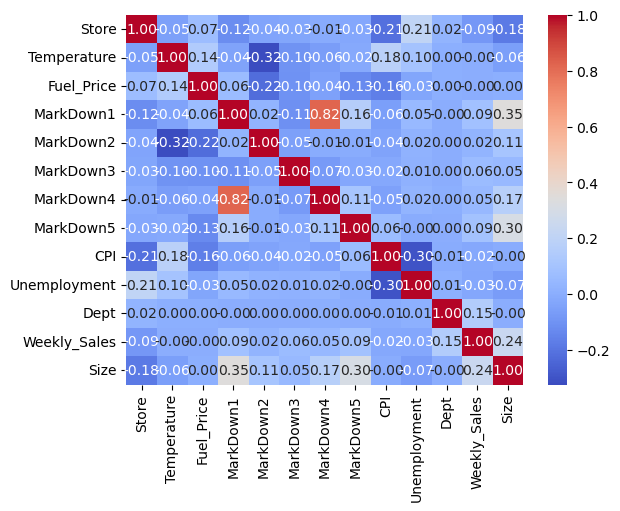

In [21]:
# Let's observe the influence between variables using correlation
# Create a heatmap of the correlation matrix
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
# 0.21 weak correlation between store and CPI
# 0.32 weak correlation between temp and Markdown 2
# 0.82 strong correlation between Markdown 1 and Markdown 4
# 0.35 moderate correlation between Markdown 1 and size

In [36]:
merged_data_df['Weekly_Sales'].unique()

array([24924.5 , 50605.27, 13740.12, ..., 56017.47,  6817.48,  1076.8 ])

In [37]:
# Aggregate sales per category within each region
merged_data_df_store = merged_data_df.groupby(['Store']).agg({'Weekly_Sales': 'sum'}).reset_index()

ValueError: Plot kind 'pie' is not recognized

<Figure size 1200x800 with 0 Axes>

## Plots through EDA


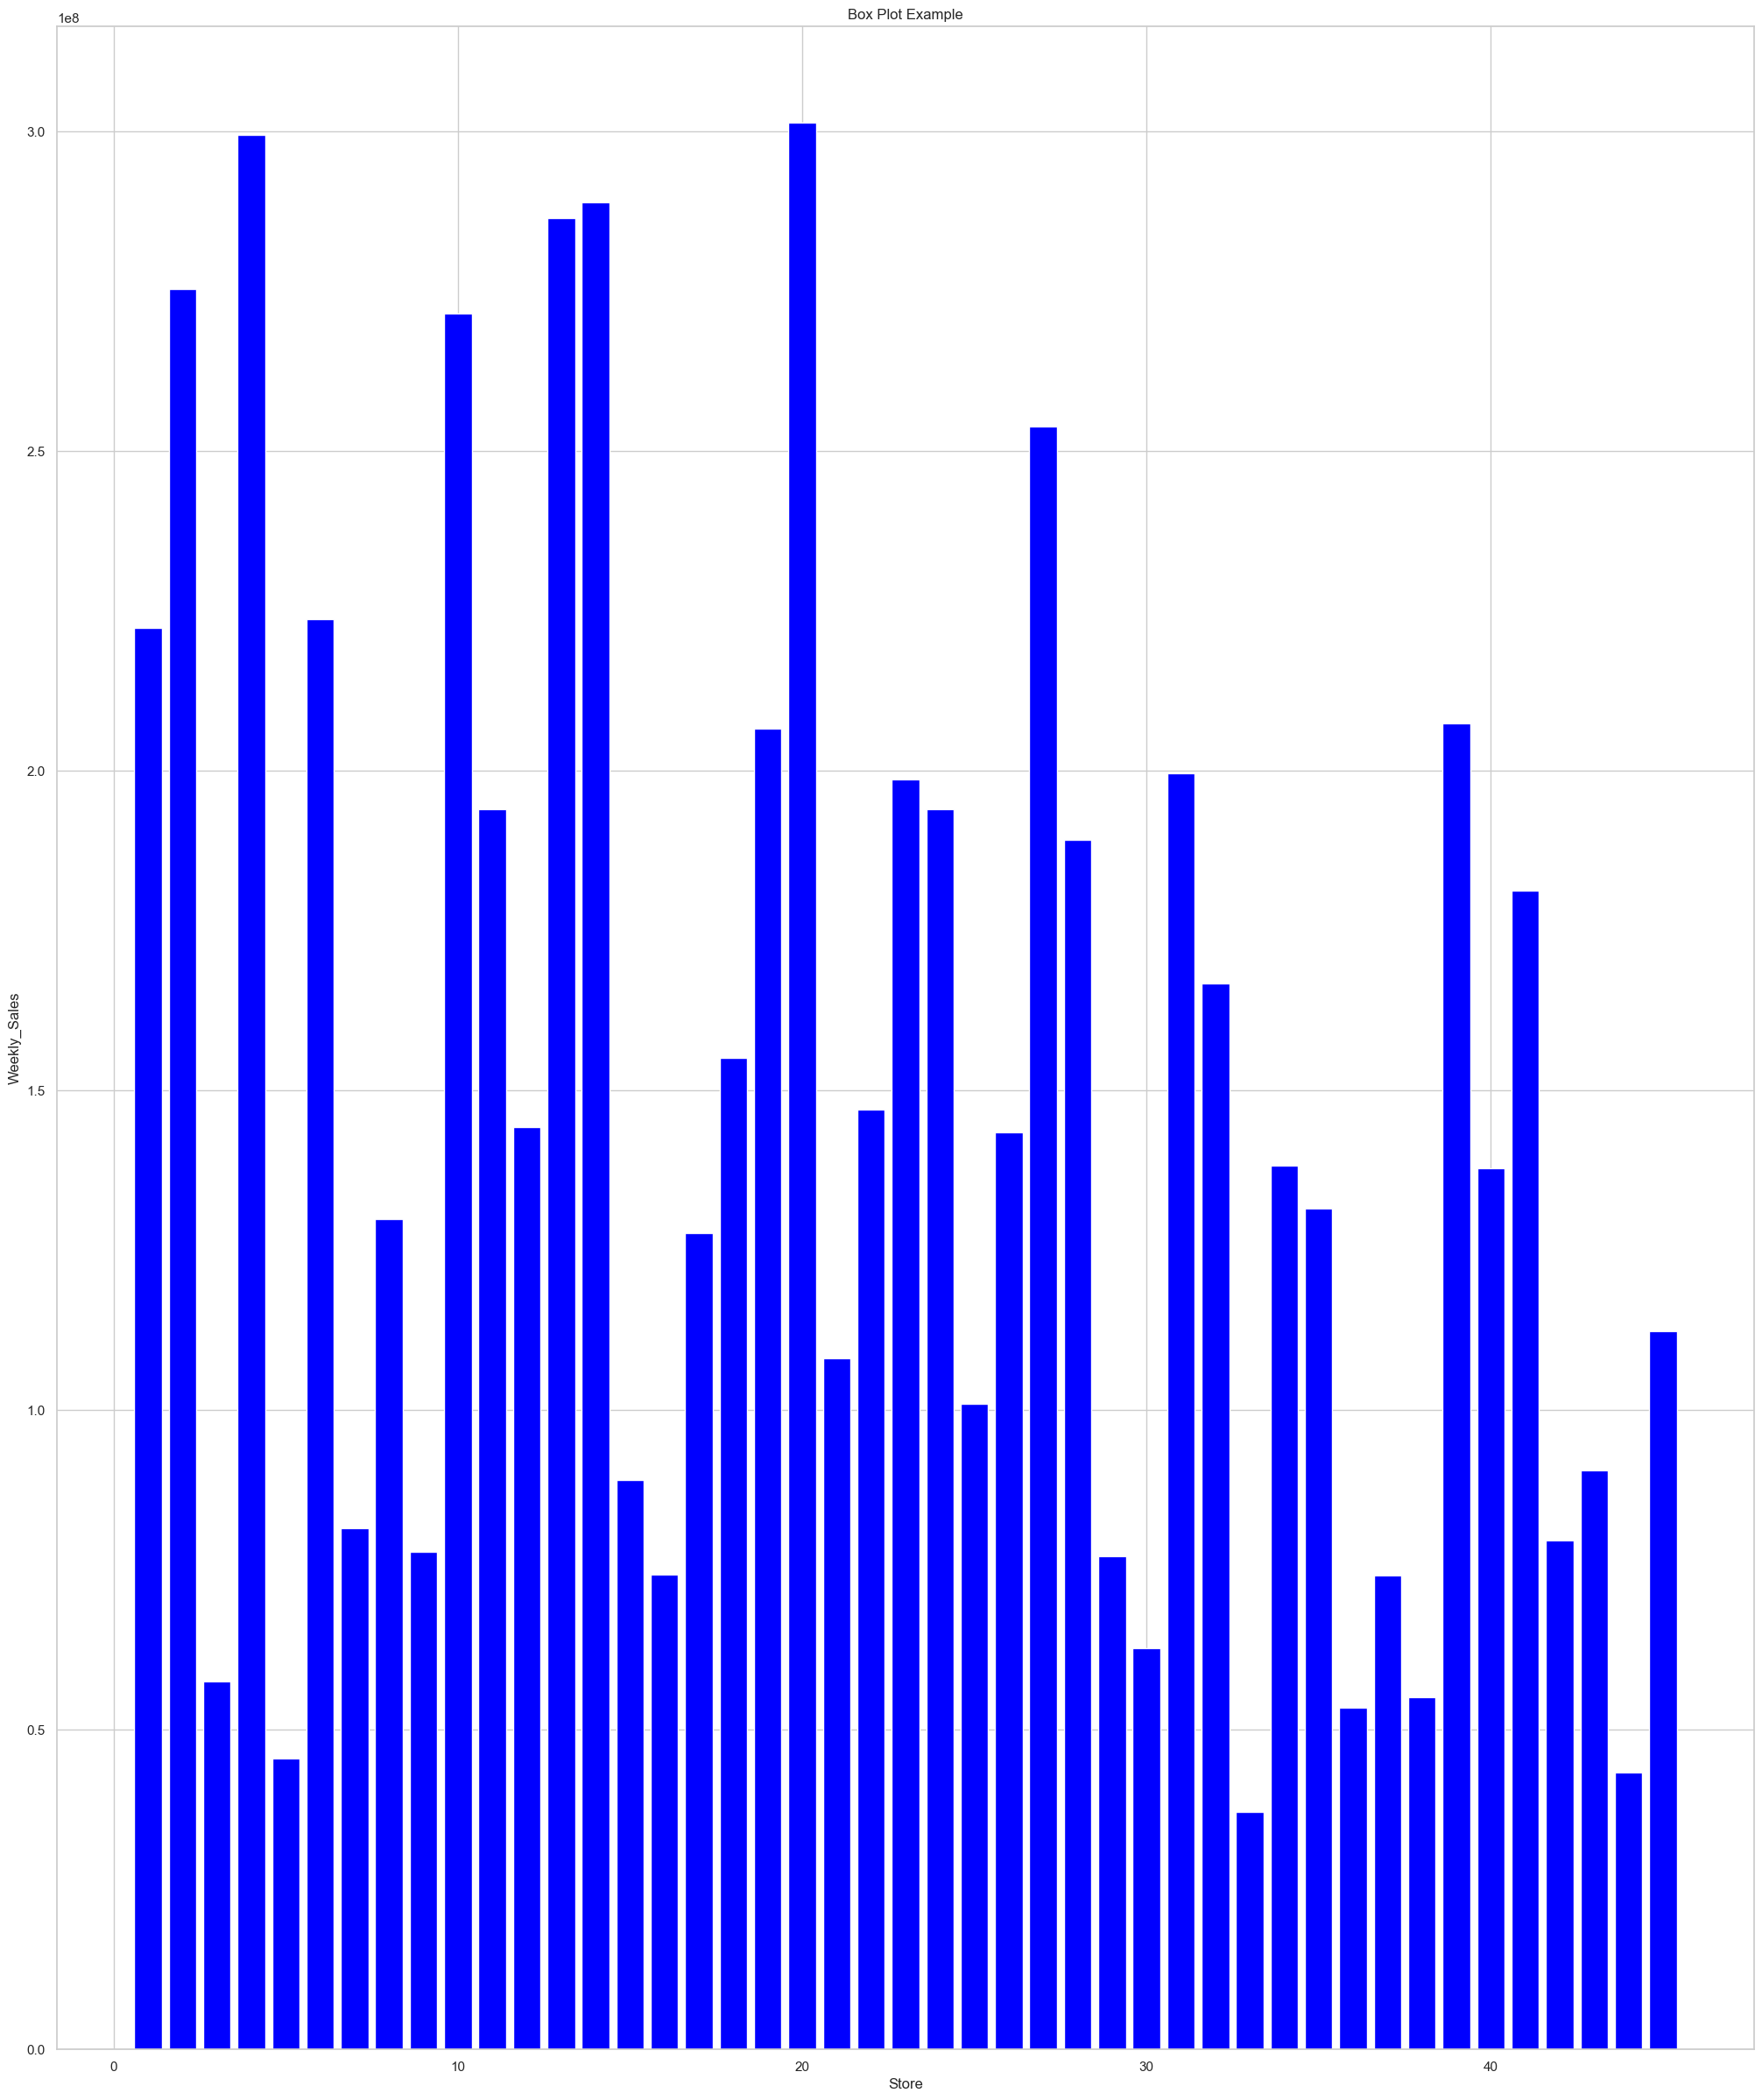

In [47]:
plt.figure(figsize=(25, 30))
# Create a bar plot
# Use the bar() function to create the bar chart
plt.bar(merged_data_df_store['Store'], merged_data_df_store['Weekly_Sales'], color='blue')

# Add title and labels
plt.title('Box Plot Example')
plt.xlabel('Store')
plt.ylabel('Weekly_Sales')

# Display the plot
plt.show()

In [48]:
# Aggregate sales per category within each region
merged_data_df_dept = merged_data_df.groupby(['Dept']).agg({'Weekly_Sales': 'sum'}).reset_index()

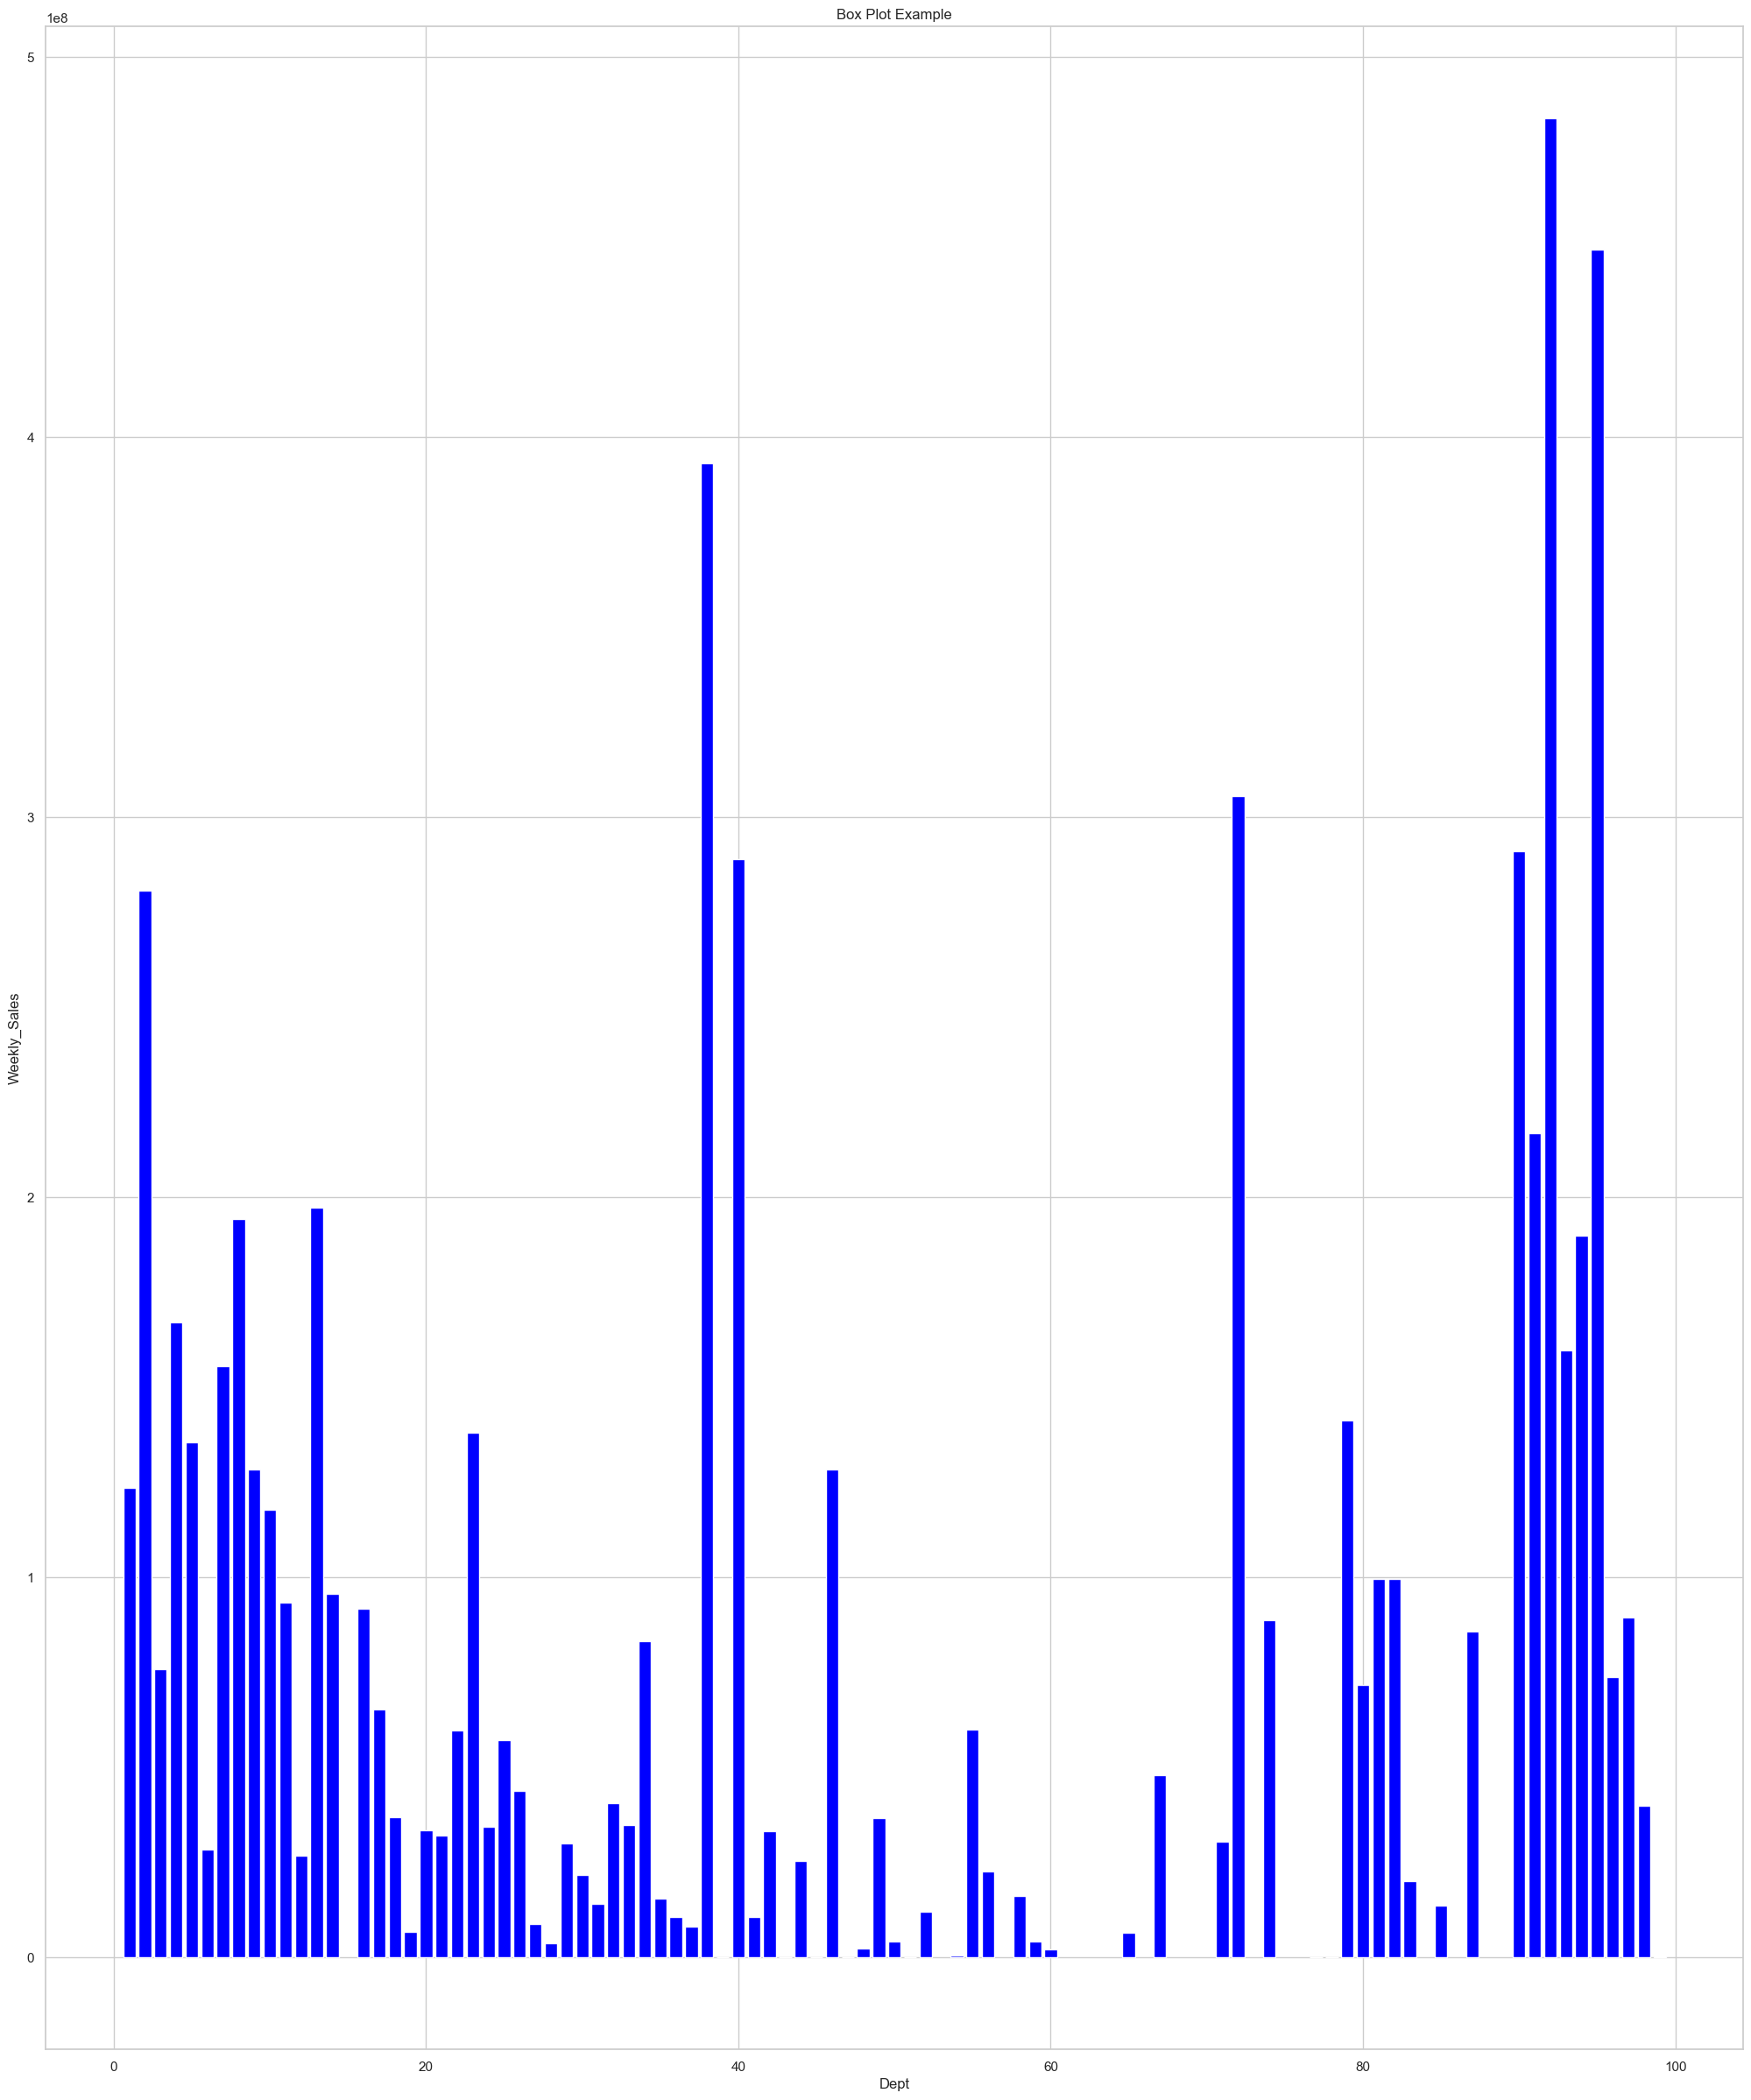

In [50]:
plt.figure(figsize=(25, 30))
# Create a bar plot
# Use the bar() function to create the bar chart
plt.bar(merged_data_df_dept['Dept'], merged_data_df_dept['Weekly_Sales'], color='blue')

# Add title and labels
plt.title('Box Plot Example')
plt.xlabel('Dept')
plt.ylabel('Weekly_Sales')

# Display the plot
plt.show()

In [52]:
merged_data_df_dept['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)